## Task

- get some topics from freeform text survey answers

In [2]:
import pandas as pd
import numpy as np
import ast
import spacy
from pandas.io.parsers.readers import fill
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from ydata_profiling import ProfileReport

import plotly.express as px
import matplotlib.pyplot as plt

from itertools import chain
from collections import Counter

import logging
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

nlp = spacy.load('en_core_web_lg')

/home/x/.cache/pypoetry/virtualenvs/mental-health-awareness-uk6wyTir-py3.11/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Explore

In [3]:
data = pd.read_csv('dataset/intake_assesment_postgres - intake_assesment_postgres.csv')
data.dropna(subset=['auth0_id'], inplace=True)  # drop 2 rows
data['user'] = data['auth0_id'].map(lambda x: hash(x + 'sa1t_5417'))
data.drop(columns=['auth0_id', 'IDENTIFIED_CATEGORY_LIST'], inplace=True)
data['value'] = data['value'].str.replace('\n', ' ')

freeform_keys = {
    "What is the biggest goal or improvement you'd like to focus on while working with Lifeforce?": "goal",
    "What is your biggest complaint or concern you would like to address while working with Lifeforce?": "concern",
}
data['key'].replace(freeform_keys, inplace=True)
data['freeform_value'] = data['key'].isin(['concern', 'goal'])

ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split datasets

In [4]:
data_cat = data[~data['freeform_value']].copy()
data_freeform = data[data['freeform_value']].copy()

data_cat['value'] = data_cat['value'].map(ast.literal_eval)
data_freeform['value'].fillna('', inplace=True)

## Categorical

<Axes: title={'center': 'data_important'}, xlabel='value'>

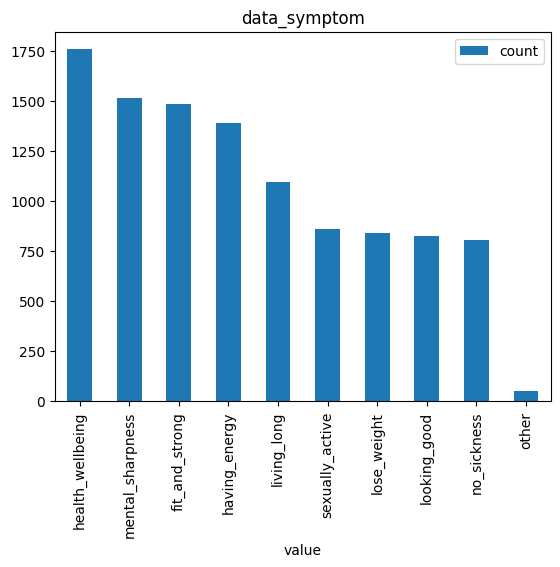

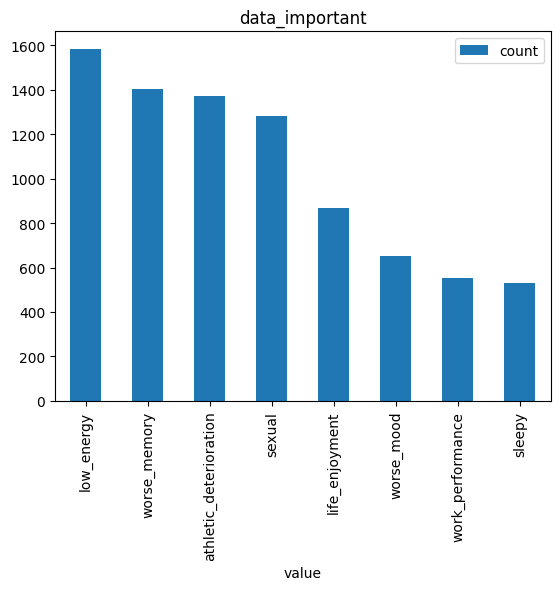

In [5]:
%matplotlib inline

data_cat[data_cat['key'] == 'important']['value'].explode().value_counts().reset_index().plot.bar(x='value', y='count', title='data_symptom')
data_cat[data_cat['key'] == 'symptom']['value'].explode().value_counts().reset_index().plot.bar(x='value', y='count', title='data_important')

## LDA analysis of free form text

### Dictionary

In [6]:
pos_blacklist = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
token_blacklist = ['f', 'd', 'want', 'like', 'go', 'improve', 'increase']

tokens = []
for doc in nlp.pipe(data_freeform['value'].values):
    #proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in rm_pos and not token.is_stop and token.is_alpha]
    proj_tok = [
        token.lemma_.lower() for token in doc
        if token.is_alpha
        and not token.is_stop
        and token.text not in token_blacklist
        and token.pos_ not in pos_blacklist
    ]
    tokens.append(proj_tok)
data_freeform['tokens'] = tokens

bigram_model = Phrases(data_freeform['tokens'], min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
data_freeform['tokens'] = bigram_model[data_freeform['tokens']]
#trigram_model = Phrases(data_freeform['tokens'], min_count=1, threshold=1, connector_words=ENGLISH_CONNECTOR_WORDS)
#data_freeform['tokens'] = trigram_model[data_freeform['tokens']]

dictionary = Dictionary(data_freeform['tokens'])
dictionary.filter_extremes(no_below=2, no_above=0.5)
print(dictionary)

data_freeform['bow'] = data_freeform['tokens'].map(dictionary.doc2bow)
corpus = data_freeform['bow'].values

display(data_freeform)

Dictionary<5878 unique tokens: ['body_comp', 'energy_level', 'pain', 'energy', 'longevity']...>


,answer_created_at,key,value,user,freeform_value,tokens,bow
8,2023-08-14,concern,"Energy levels, pain, body comp",7873127729179396598,True,"[energy_level, pain, body_comp]","[(0, 1), (1, 1), (2, 1)]"
9,2023-08-14,goal,"Energy, pain free and longevity",7873127729179396598,True,"[energy, pain_free, longevity]","[(3, 1), (4, 1), (5, 1)]"
18,2022-11-02,goal,Sleep and brain function,-3603555120334326870,True,"[sleep, brain_function]","[(6, 1), (7, 1)]"
19,2022-11-02,concern,"Sleep, brain",-3603555120334326870,True,"[sleep, brain]","[(7, 1), (8, 1)]"
20,2022-09-26,goal,Lower cholesterol,-3681692958331185022,True,[low_cholesterol],"[(9, 1)]"
...,...,...,...,...,...,...,...
20796,2023-08-30,goal,"Optimal weight, eliminate head and hip/leg pai...",3974268322390823426,True,"[optimal, weight, eliminate, head, hip_leg, pa...","[(2, 1), (56, 1), (58, 1), (522, 1), (704, 1),..."
20797,2023-08-30,concern,Ensure bone health and hormone health is good ...,-8179914144901306316,True,"[ensure, bone_health, hormone, health, good, o...","[(32, 1), (67, 1), (87, 1), (125, 1), (369, 1)..."
20798,2023-08-30,goal,"Hormone health, bone health and longevity.",-8179914144901306316,True,"[hormone, health, bone_health, longevity]","[(4, 1), (32, 1), (87, 1), (544, 1)]"
20799,2023-08-30,goal,"Building my immune system, imflamation and aci...",4558810405411345656,True,"[build, immune_system, imflamation, acid_reflux]","[(254, 1), (611, 1), (4406, 1)]"


<Axes: title={'center': 'data_concern'}, xlabel='tokens'>

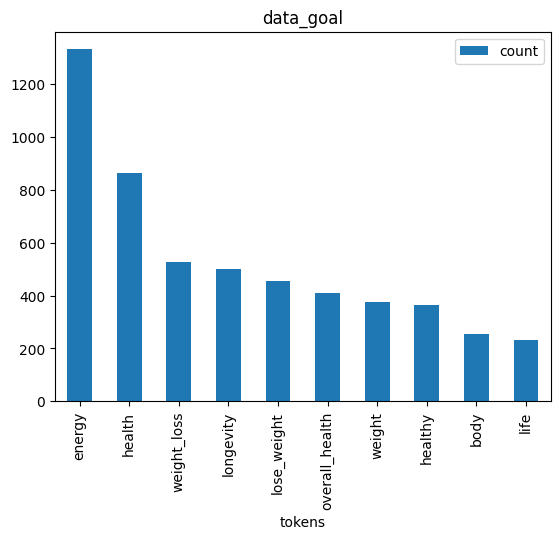

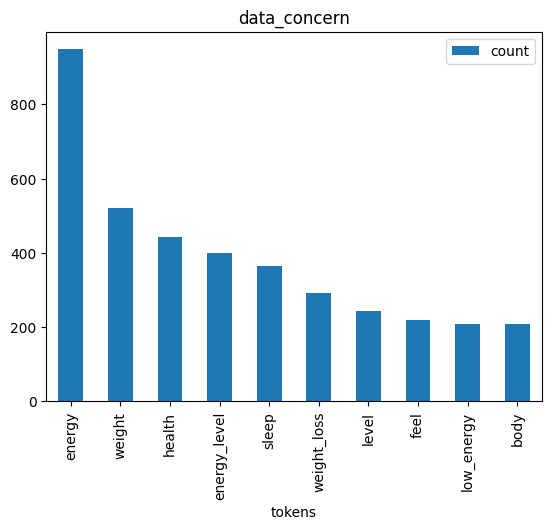

In [7]:
%matplotlib inline

data_freeform[data_freeform['key'] == 'goal']['tokens'].explode().value_counts().reset_index()[:10].plot.bar(x='tokens', y='count', title='data_goal')
data_freeform[data_freeform['key'] == 'concern']['tokens'].explode().value_counts().reset_index()[:10].plot.bar(x='tokens', y='count', title='data_concern')

In [11]:
topics = []
cohs = []

for i in tqdm(range(5, 15)):
    lda_try = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=i, workers=8, passes=1, random_state=0)
    topics.append(i)
    cohs.append(CoherenceModel(model=lda_try, texts=data_freeform['value'], corpus=corpus, dictionary=dictionary, coherence='u_mass').get_coherence())

coherence = pd.DataFrame([topics, cohs]).T
coherence.columns = ['num_topics', 'u_mass']
print(coherence)

100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:46<00:00, 10.65s/it]

   num_topics    u_mass
0         5.0 -6.119658
1         6.0 -6.202315
2         7.0 -6.331468
3         8.0 -6.632266
4         9.0 -7.272124
5        10.0 -7.653505
6        11.0 -8.076838
7        12.0 -7.263183
8        13.0 -7.781843
9        14.0 -7.984652


In [8]:
lda = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=15, workers=8, passes=20, chunksize=20000, random_state=0)

topic_map = {k: v for k, v in lda.print_topics(num_words=2)}
display(topic_map)

data_freeform["topics"] = data_freeform["bow"].map(lambda c: [topic_map[t] for t, w in lda[c] if w > 0.3])

{0: '0.173*"weight_loss" + 0.113*"lose_weight"',
 1: '0.061*"level" + 0.031*"lack_energy"',
 2: '0.063*"sleep" + 0.032*"body_fat"',
 3: '0.038*"sex_drive" + 0.037*"energy"',
 4: '0.117*"weight" + 0.051*"low_energy"',
 5: '0.064*"hormone_balance" + 0.058*"libido"',
 6: '0.118*"health" + 0.032*"improve"',
 7: '0.050*"increase_energy" + 0.030*"body_composition"',
 8: '0.053*"fat" + 0.015*"build_muscle"',
 9: '0.114*"overall_health" + 0.036*"health"',
 10: '0.128*"energy_level" + 0.030*"balance_hormone"',
 11: '0.318*"energy" + 0.062*"longevity"',
 12: '0.032*"optimal_health" + 0.029*"energy_focus"',
 13: '0.102*"healthy" + 0.027*"well_health"',
 14: '0.024*"brain_fog" + 0.022*"energy"'}

In [9]:
display(data_freeform)

,answer_created_at,key,value,user,freeform_value,tokens,bow,topics
8,2023-08-14,concern,"Energy levels, pain, body comp",7873127729179396598,True,"[energy_level, pain, body_comp]","[(0, 1), (1, 1), (2, 1)]","[0.128*""energy_level"" + 0.030*""balance_hormone""]"
9,2023-08-14,goal,"Energy, pain free and longevity",7873127729179396598,True,"[energy, pain_free, longevity]","[(3, 1), (4, 1), (5, 1)]","[0.318*""energy"" + 0.062*""longevity""]"
18,2022-11-02,goal,Sleep and brain function,-3603555120334326870,True,"[sleep, brain_function]","[(6, 1), (7, 1)]","[0.064*""hormone_balance"" + 0.058*""libido""]"
19,2022-11-02,concern,"Sleep, brain",-3603555120334326870,True,"[sleep, brain]","[(7, 1), (8, 1)]","[0.063*""sleep"" + 0.032*""body_fat""]"
20,2022-09-26,goal,Lower cholesterol,-3681692958331185022,True,[low_cholesterol],"[(9, 1)]","[0.114*""overall_health"" + 0.036*""health""]"
...,...,...,...,...,...,...,...,...
20796,2023-08-30,goal,"Optimal weight, eliminate head and hip/leg pai...",3974268322390823426,True,"[optimal, weight, eliminate, head, hip_leg, pa...","[(2, 1), (56, 1), (58, 1), (522, 1), (704, 1),...","[0.063*""sleep"" + 0.032*""body_fat""]"
20797,2023-08-30,concern,Ensure bone health and hormone health is good ...,-8179914144901306316,True,"[ensure, bone_health, hormone, health, good, o...","[(32, 1), (67, 1), (87, 1), (125, 1), (369, 1)...","[0.118*""health"" + 0.032*""improve""]"
20798,2023-08-30,goal,"Hormone health, bone health and longevity.",-8179914144901306316,True,"[hormone, health, bone_health, longevity]","[(4, 1), (32, 1), (87, 1), (544, 1)]","[0.118*""health"" + 0.032*""improve""]"
20799,2023-08-30,goal,"Building my immune system, imflamation and aci...",4558810405411345656,True,"[build, immune_system, imflamation, acid_reflux]","[(254, 1), (611, 1), (4406, 1)]","[0.050*""increase_energy"" + 0.030*""body_composi..."


In [ ]:
data_freeform[:30].to_markdown()

## Possible improvements

- Autocorrect typos
- Use a corpus model for LDA topics
- Use sentiment
- Use POS
- use tSNE to explain topic vecs